In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy

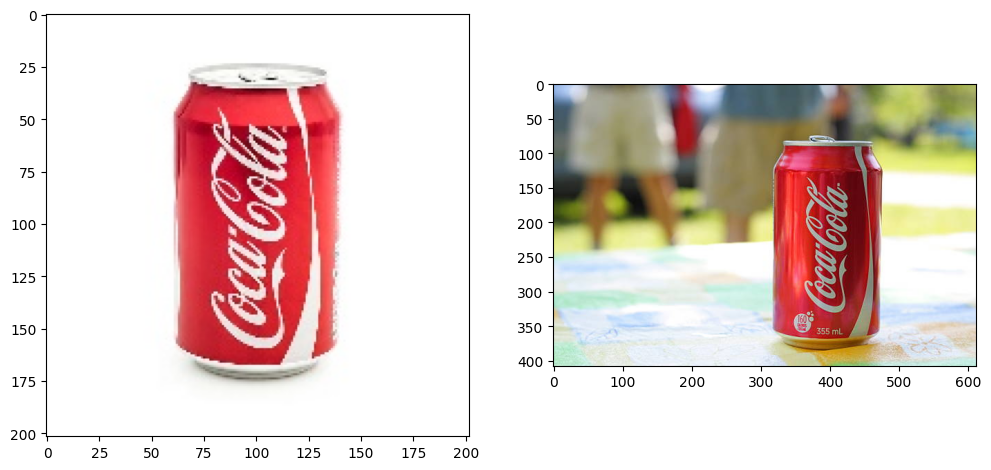

In [2]:
coke = cv2.imread('data/coke.jpg')
table = cv2.imread('data/coke-table.jpg')
f, (a1, a2) = plt.subplots(1, 2, figsize=(12,12))
a1.imshow(coke[..., ::-1]);
a2.imshow(table[..., ::-1]);

In [3]:
def get_max_dist(matches):
    dist_sum = 1
    for query in matches:
        for train in query:
            dist_sum += train.distance
    return dist_sum

def create_matrix(matches, max_idx_kp1, max_idx_kp2, padding_value=100_000):
    # Znajdź maksymalne indeksy w obu wymiarach
    matrix_size = max(max_idx_kp1, max_idx_kp2)
    # Inicjalizuj macierz z wartościami paddingu
    matrix = np.full((matrix_size, matrix_size), padding_value, dtype=int)

    for idx_kp1, query in enumerate(matches):
        for train in query:
            matrix[idx_kp1, train.trainIdx] = train.distance
    # Wypełnij macierz wartościami z matches


    return matrix

## Badanie distance_tresholds

In [ ]:
sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(coke, mask=None)
kp2, ds2 = sift.detectAndCompute(table, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
    
    
distance_tresholds = [x for x in range(50, 500, 30)]
plt.figure(figsize=(40, 40))
rows = 15
for x in range(rows):
    best_matches = [match for match in matches if match.distance < distance_tresholds[x]]
    show_matches = cv2.drawMatches(coke, kp1, table, kp2, best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
    plt.subplot(4, 4, x+1)
    plt.imshow(show_matches[..., ::-1]), plt.title(f'SIFT  distance_tresh:{distance_tresholds[x]}')

plt.tight_layout()
plt.show()

plt.show()

## using k-best

In [ ]:

k = 2
only_one = True

# Create SIFT object
sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(coke, mask=None)
kp2, ds2 = sift.detectAndCompute(table, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.knnMatch(ds1, ds2, k)

# Distance ratio test to filter out ambiguous matches


# Plot the matches for different distance thresholds
distance_thresholds = [x for x in range(50, 500, 30)]
plt.figure(figsize=(40, 40))
rows = 15

for x in range(rows):
    if only_one:
        good_matches = []
        for m, n in matches:
            if m.distance <  n.distance:
                good_matches.append(m)
            else:
                good_matches.append(n)
        threshold = distance_thresholds[x]
        filtered_matches = [match for match in good_matches if match.distance < threshold]
        show_matches = cv2.drawMatches(coke, kp1, table, kp2, filtered_matches, None, matchColor=(0, 255, 0),
                                singlePointColor=(0, 0, 255))
    else:
        threshold = distance_thresholds[x]
        filtered_matches = [tuple(match for match in knn_neigbors if match.distance < threshold) for knn_neigbors in matches]
        show_matches = cv2.drawMatchesKnn(coke, kp1, table, kp2, filtered_matches, None, matchColor=(0, 255, 0),
                                singlePointColor=(0, 0, 255))

    plt.subplot(4, 4, x + 1)
    plt.imshow(show_matches[..., ::-1]), plt.title(f'SIFT k-NN Distance Threshold: {threshold}')

plt.tight_layout()
plt.show()


## using k-best to maximum perfect matching keypoints, idea used in my engineering thesis

In [ ]:
k = 2
only_one = False
perfect = True

# Create SIFT object
sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(coke, mask=None)
kp2, ds2 = sift.detectAndCompute(table, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.knnMatch(ds1, ds2, k)

# Distance ratio test to filter out ambiguous matches


# Plot the matches for different distance thresholds
distance_thresholds = [x for x in range(50, 500, 30)]
plt.figure(figsize=(40, 40))
rows = 15

for x in range(rows):
    if only_one:
        good_matches = []
        for m, n in matches:
            if m.distance <  n.distance:
                good_matches.append(m)
            else:
                good_matches.append(n)
        threshold = distance_thresholds[x]
        filtered_matches = [match for match in good_matches if match.distance < threshold]
        show_matches = cv2.drawMatches(coke, kp1, table, kp2, filtered_matches, None, matchColor=(0, 255, 0),
                                singlePointColor=(0, 0, 255))
    else:
        threshold = distance_thresholds[x]
        if perfect:
            filtered_matches = [tuple(match for match in knn_neigbors if match.distance < threshold) for knn_neigbors in matches]
            good_matches = []
            max_kp1 = len(kp1)
            max_kp2 = len(kp2)
            matrix = create_matrix(filtered_matches,max_kp1, max_kp2, get_max_dist(filtered_matches))
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(matrix)
            for query_idx in range(max_kp1):
                for train in filtered_matches[query_idx]:
                    if train.trainIdx == col_ind[query_idx]:
                        good_matches.append(train)
                        break
            
            show_matches = cv2.drawMatches(coke, kp1, table, kp2, good_matches, None, matchColor=(0, 255, 0),
                                singlePointColor=(0, 0, 255))
            
        else:
            filtered_matches = [tuple(match for match in knn_neigbors if match.distance < threshold) for knn_neigbors in matches]
            show_matches = cv2.drawMatchesKnn(coke, kp1, table, kp2, filtered_matches, None, matchColor=(0, 255, 0),
                                singlePointColor=(0, 0, 255))

    plt.subplot(4, 4, x + 1)
    plt.imshow(show_matches[..., ::-1]), plt.title(f'SIFT k-NN Distance Threshold: {threshold}')

plt.tight_layout()
plt.show()


In [7]:
def remove(matches1, matches2):
    new_matches1, new_matches2 = [], []
    for match1 in matches1:
        for match2 in matches2:
            if match1.queryIdx == match2.queryIdx:
                if match1.trainIdx != match2.trainIdx:
                    new_matches1.append(match1)
                    new_matches2.append(match2)
            else:
                if match1.trainIdx == match2.trainIdx:
                    new_matches1.append(match1)
                    new_matches2.append(match2)
    return new_matches1, new_matches2
                    
            

chart showing difference beetwen k1 sift and my maximum perfect matching

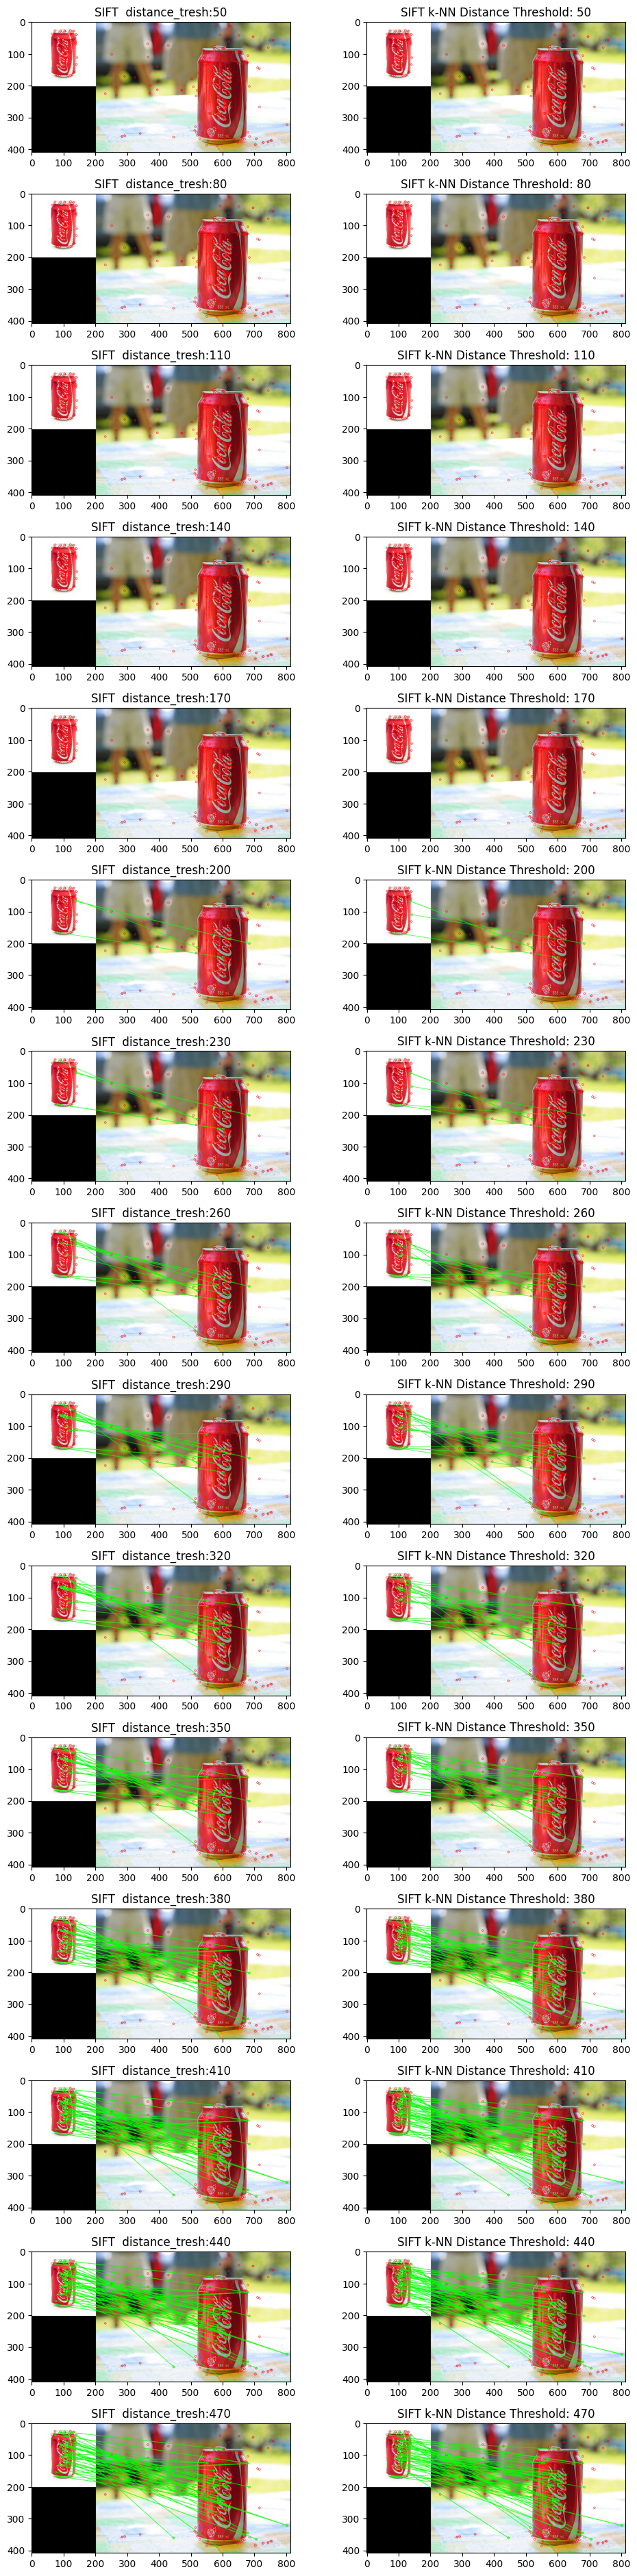

In [8]:

# Assuming 'coke' and 'table' are your image arrays
k = 2
only_one = False
perfect = True

# Create SIFT object
sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(coke, mask=None)
kp2, ds2 = sift.detectAndCompute(table, mask=None)
matcher_knn = cv2.BFMatcher_create()
matches_knn = matcher_knn.knnMatch(ds1, ds2, k)
matcher_bfm = cv2.BFMatcher_create()
matches_bfm = matcher_bfm.match(ds1, ds2)
# Distance ratio test to filter out ambiguous matches


# Plot the matches for different distance thresholds
distance_thresholds = [x for x in range(50, 500, 30)]
plt.figure(figsize=(10, 40))
rows = 15

for x in range(rows):
    best_matches = [match for match in matches_bfm if match.distance < distance_tresholds[x]]
    


    threshold = distance_thresholds[x]
    filtered_matches = [tuple(match for match in knn_neigbors if match.distance < threshold) for knn_neigbors in matches_knn]
    good_matches = []
    max_kp1 = len(kp1)
    max_kp2 = len(kp2)
    matrix = create_matrix(filtered_matches,max_kp1, max_kp2, get_max_dist(filtered_matches)*10)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(matrix)
    for query_idx in range(max_kp1):
        for train in filtered_matches[query_idx]:
            if train.trainIdx == col_ind[query_idx]:
                good_matches.append(train)
                break

    
    good_matches, best_matches = remove(good_matches, best_matches)

    
    show_matches = cv2.drawMatches(coke, kp1, table, kp2, best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
    plt.subplot(16, 2, x*2+1)
    plt.imshow(show_matches[..., ::-1]), plt.title(f'SIFT  distance_tresh:{distance_tresholds[x]}')
    
    show_matches = cv2.drawMatches(coke, kp1, table, kp2, good_matches, None, matchColor=(0, 255, 0),
                        singlePointColor=(0, 0, 255))
    plt.subplot(16, 2, x*2+2)
    plt.imshow(show_matches[..., ::-1]), plt.title(f'SIFT k-NN Distance Threshold: {threshold}')

plt.tight_layout()
plt.show()


##### Transform


In [ ]:
from tracemalloc import start

sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(coke, mask=None)
kp2, ds2 = sift.detectAndCompute(table, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
N = 99999  # Możesz dostosować ilość punktów, którą chcesz użyć
selected_matches = matches[:N]
src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed_coke = cv2.warpPerspective(coke, H, (table.shape[1], table.shape[0]))



    
closeness_values = [1, 5, 10, 20, 30, 50, 70, 100, 150]
plt.figure(figsize=(40, 20))
rows = 9
for x in range(rows):
    side_by_side = np.concatenate((table, transformed_coke), axis=1)
    for match in selected_matches:
        pt1 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
        
        # Sprawdź odległość między punktami
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
        if distance < closeness_values[x]:
            pt2 = (pt2[0] + table.shape[1], pt2[1])
            cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
            cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
    plt.subplot(3, 3, x+1)
    plt.imshow(side_by_side[...,::-1]), plt.title(f'SIFT  distance_tresh:{closeness_values[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

In [ ]:
edge_tresh = [1.1, 2, 5, 30]
contrast_tresh = [_, 0.005, 0.01, 0.04, 0.08]
plt.figure(figsize=(40, 40))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kps = sift.detect(norway_copy, None)
        img_kp = cv2.drawKeypoints(norway_copy, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(img_kp[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')

plt.tight_layout()
plt.show()



plt.show()

In [ ]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999

# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
edge_tresh = [1.1, 2, 5, 200]
contrast_tresh = [_, 0.005, 0.01, 0.04, 0.08]
plt.figure(figsize=(40, 20))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kp1, ds1 = sift.detectAndCompute(coke, mask=None)
        kp2, ds2 = sift.detectAndCompute(table, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            
            selected_matches = matches[:N]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        except:
            continue
        transformed_coke = cv2.warpPerspective(coke, H, (table.shape[1], table.shape[0]))
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        
        
        side_by_side = np.concatenate((table, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + table.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')
    


plt.tight_layout()
plt.show()

plt.show()

In [ ]:
from tracemalloc import start

sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(coke, mask=None)
kp2, ds2 = sift.detectAndCompute(table, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
    
    
distance_tresholds = [x for x in range(50, 500, 30)]
plt.figure(figsize=(40, 40))
rows = 15
for x in range(rows):
    best_matches = [match for match in matches if match.distance < distance_tresholds[x]]
    show_matches = cv2.drawMatches(coke, kp1, table, kp2, best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
    plt.subplot(4, 4, x+1)
    plt.imshow(show_matches[..., ::-1]), plt.title(f'SIFT  distance_tresh:{distance_tresholds[x]}')

plt.tight_layout()
plt.show()

plt.show()

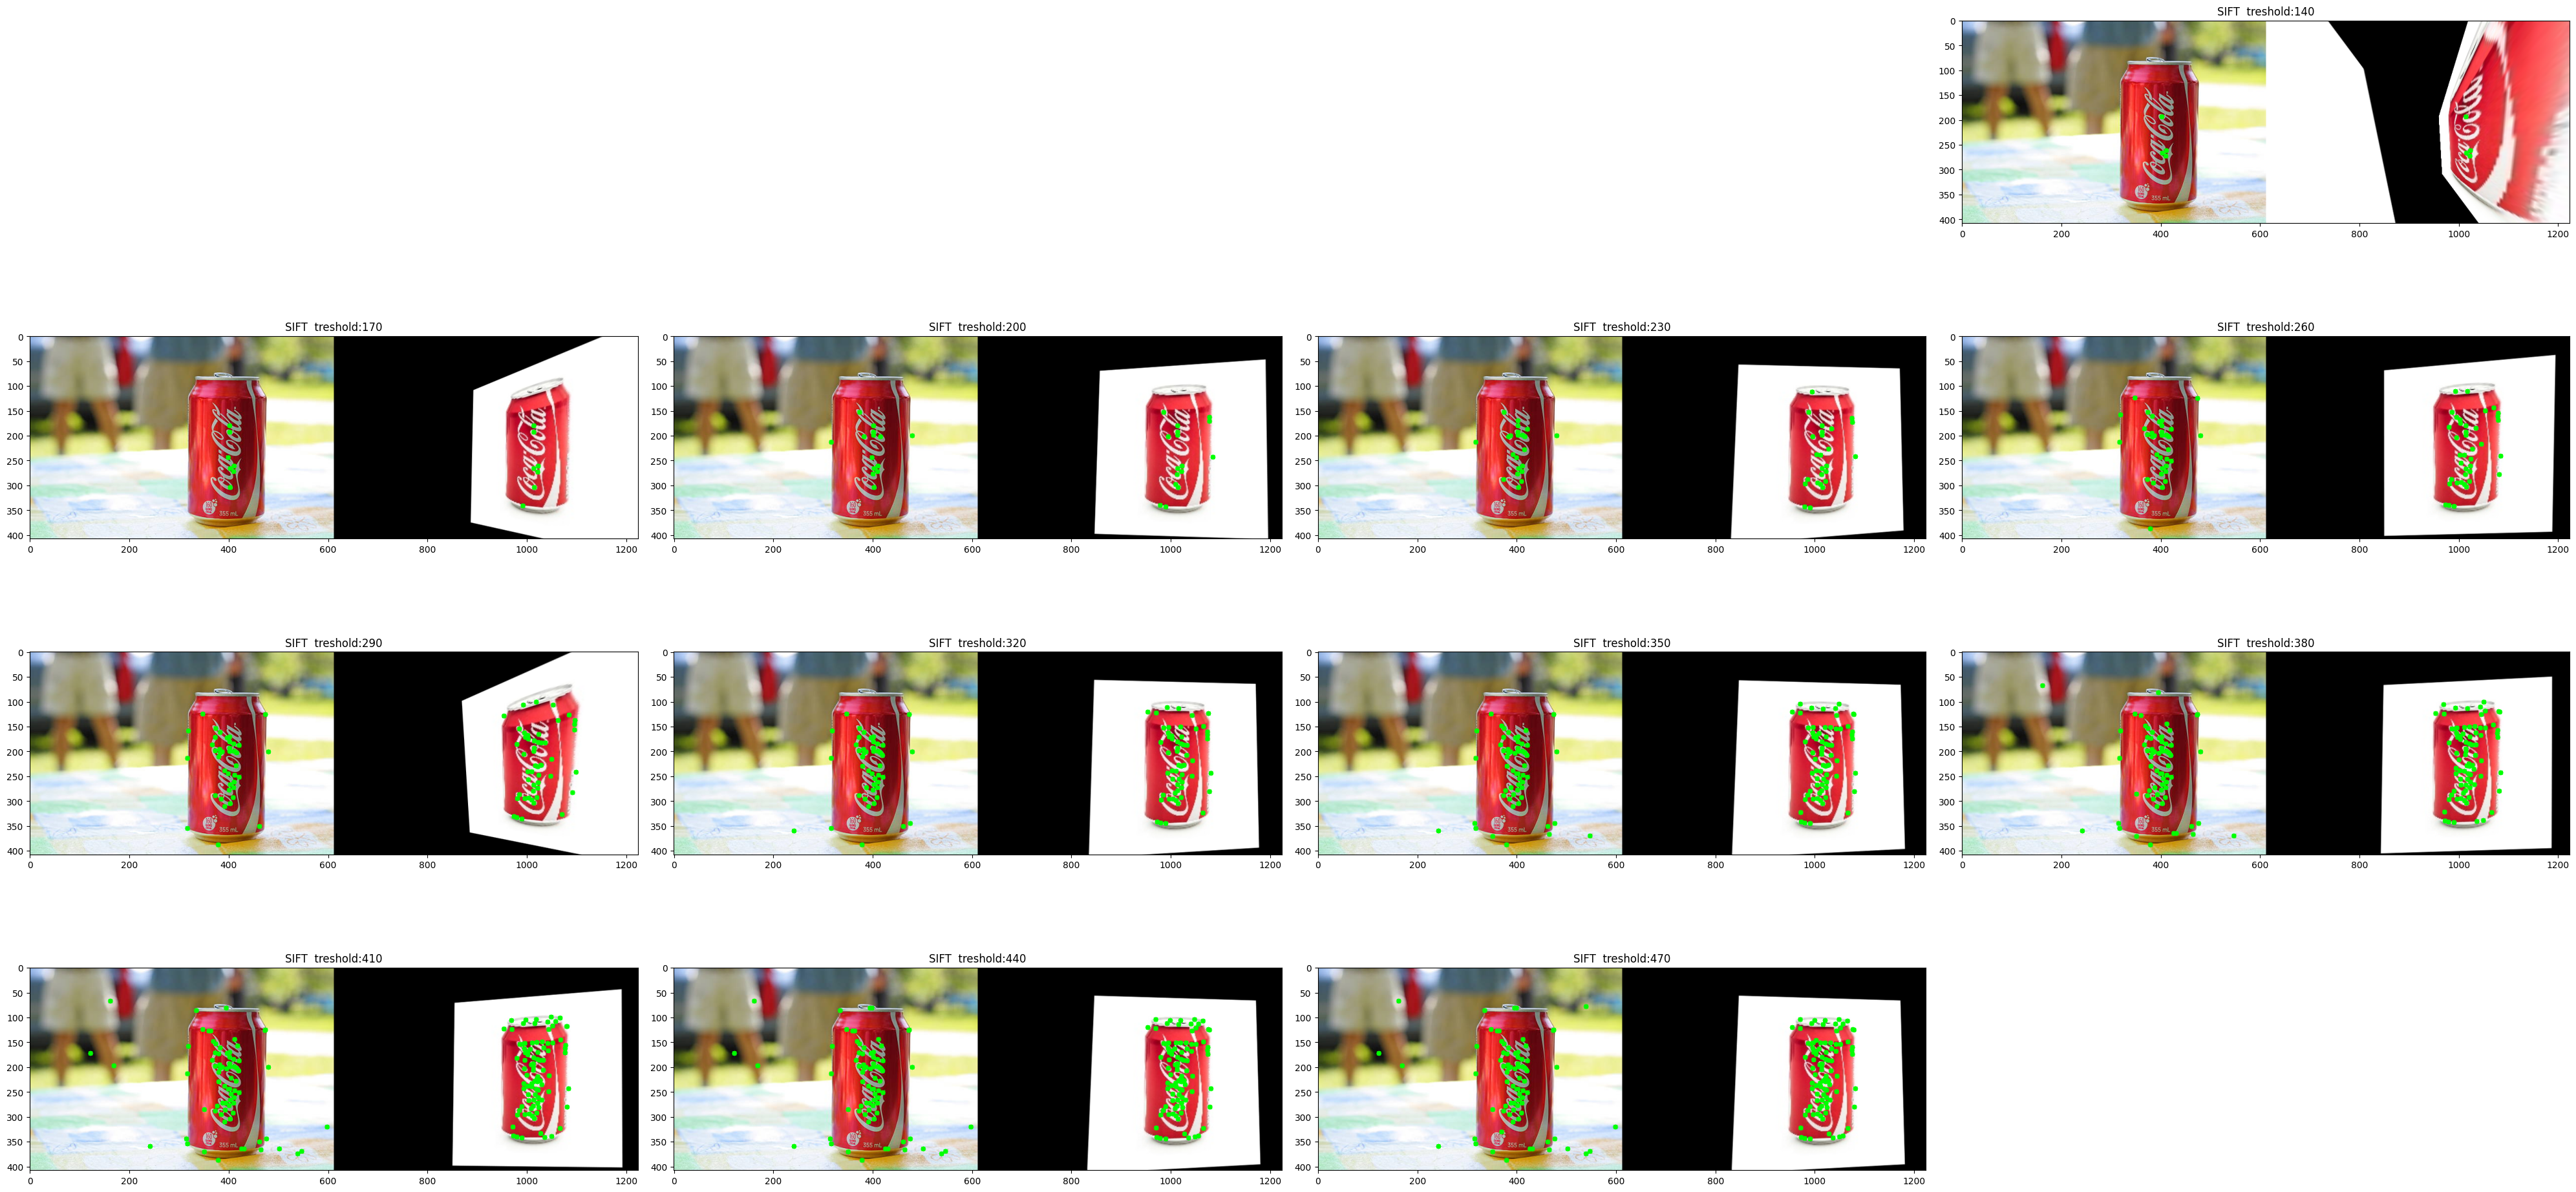

In [14]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999

# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
distance_tresholds = [x for x in range(50, 500, 30)]
plt.figure(figsize=(40, 20))
rows = 15
for x in range(rows):
        sift = cv2.SIFT_create()
        kp1, ds1 = sift.detectAndCompute(coke, mask=None)
        kp2, ds2 = sift.detectAndCompute(table, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            matches = [match for match in matches if match.distance < distance_tresholds[x]]
            selected_matches = matches[:N]
            
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        except:
            continue
        transformed_coke = cv2.warpPerspective(coke, H, (table.shape[1], table.shape[0]))
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        
        
        side_by_side = np.concatenate((table, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + table.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(4, 4, x+1)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  treshold:{distance_tresholds[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

# My photos


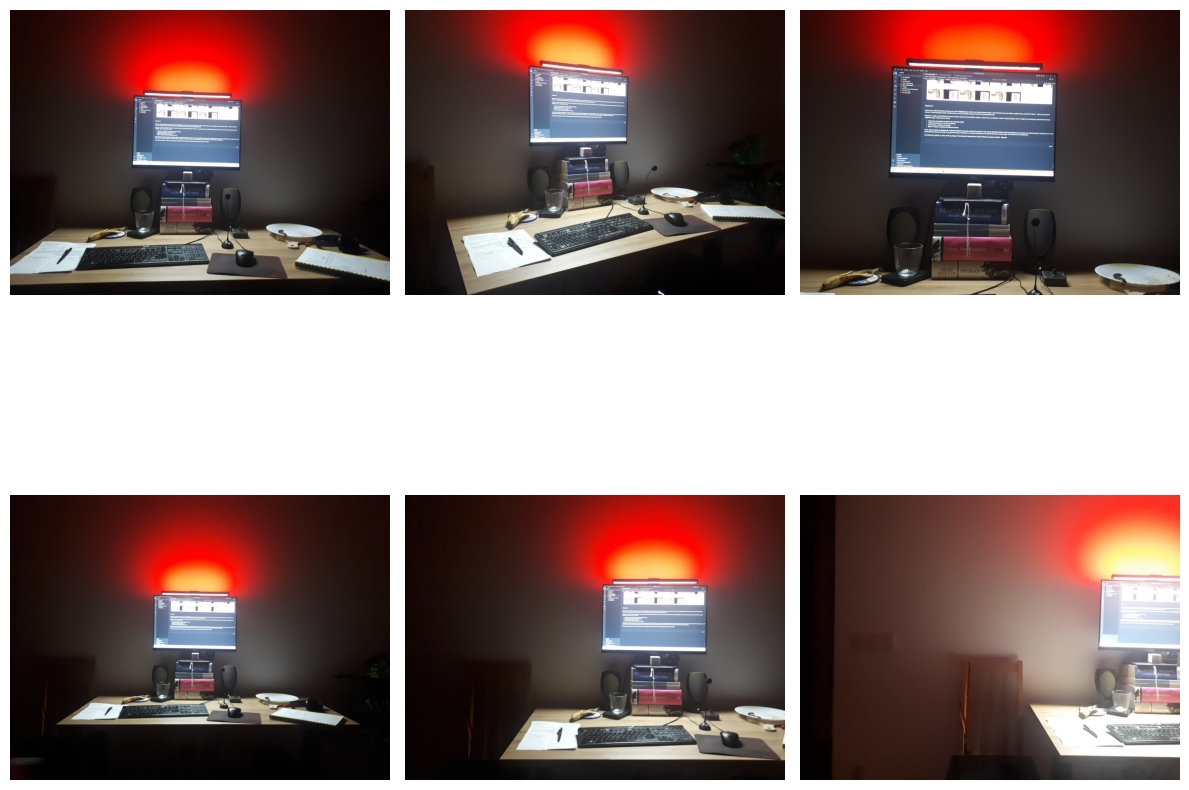

In [3]:
basic = cv2.imread('data/basic.jpg')
rot = cv2.imread('data/rot.jpg')
zoom = cv2.imread('data/zoom.jpg')
out = cv2.imread('data/out.jpg')
left = cv2.imread('data/left.jpg')
left_hard = cv2.imread('data/left_hard.jpg')


f, axes = plt.subplots(2, 3, figsize=(12, 12))
axes[0, 0].imshow(basic[..., ::-1])
axes[0, 1].imshow(rot[..., ::-1])
axes[0, 2].imshow(zoom[..., ::-1])
axes[1, 0].imshow(out[..., ::-1])
axes[1, 1].imshow(left[..., ::-1])
axes[1, 2].imshow(left_hard[..., ::-1])


for ax in axes.flat:
    ax.axis('off')  
    ax.set_aspect('equal')  
plt.tight_layout()  

plt.show()


## Zoom

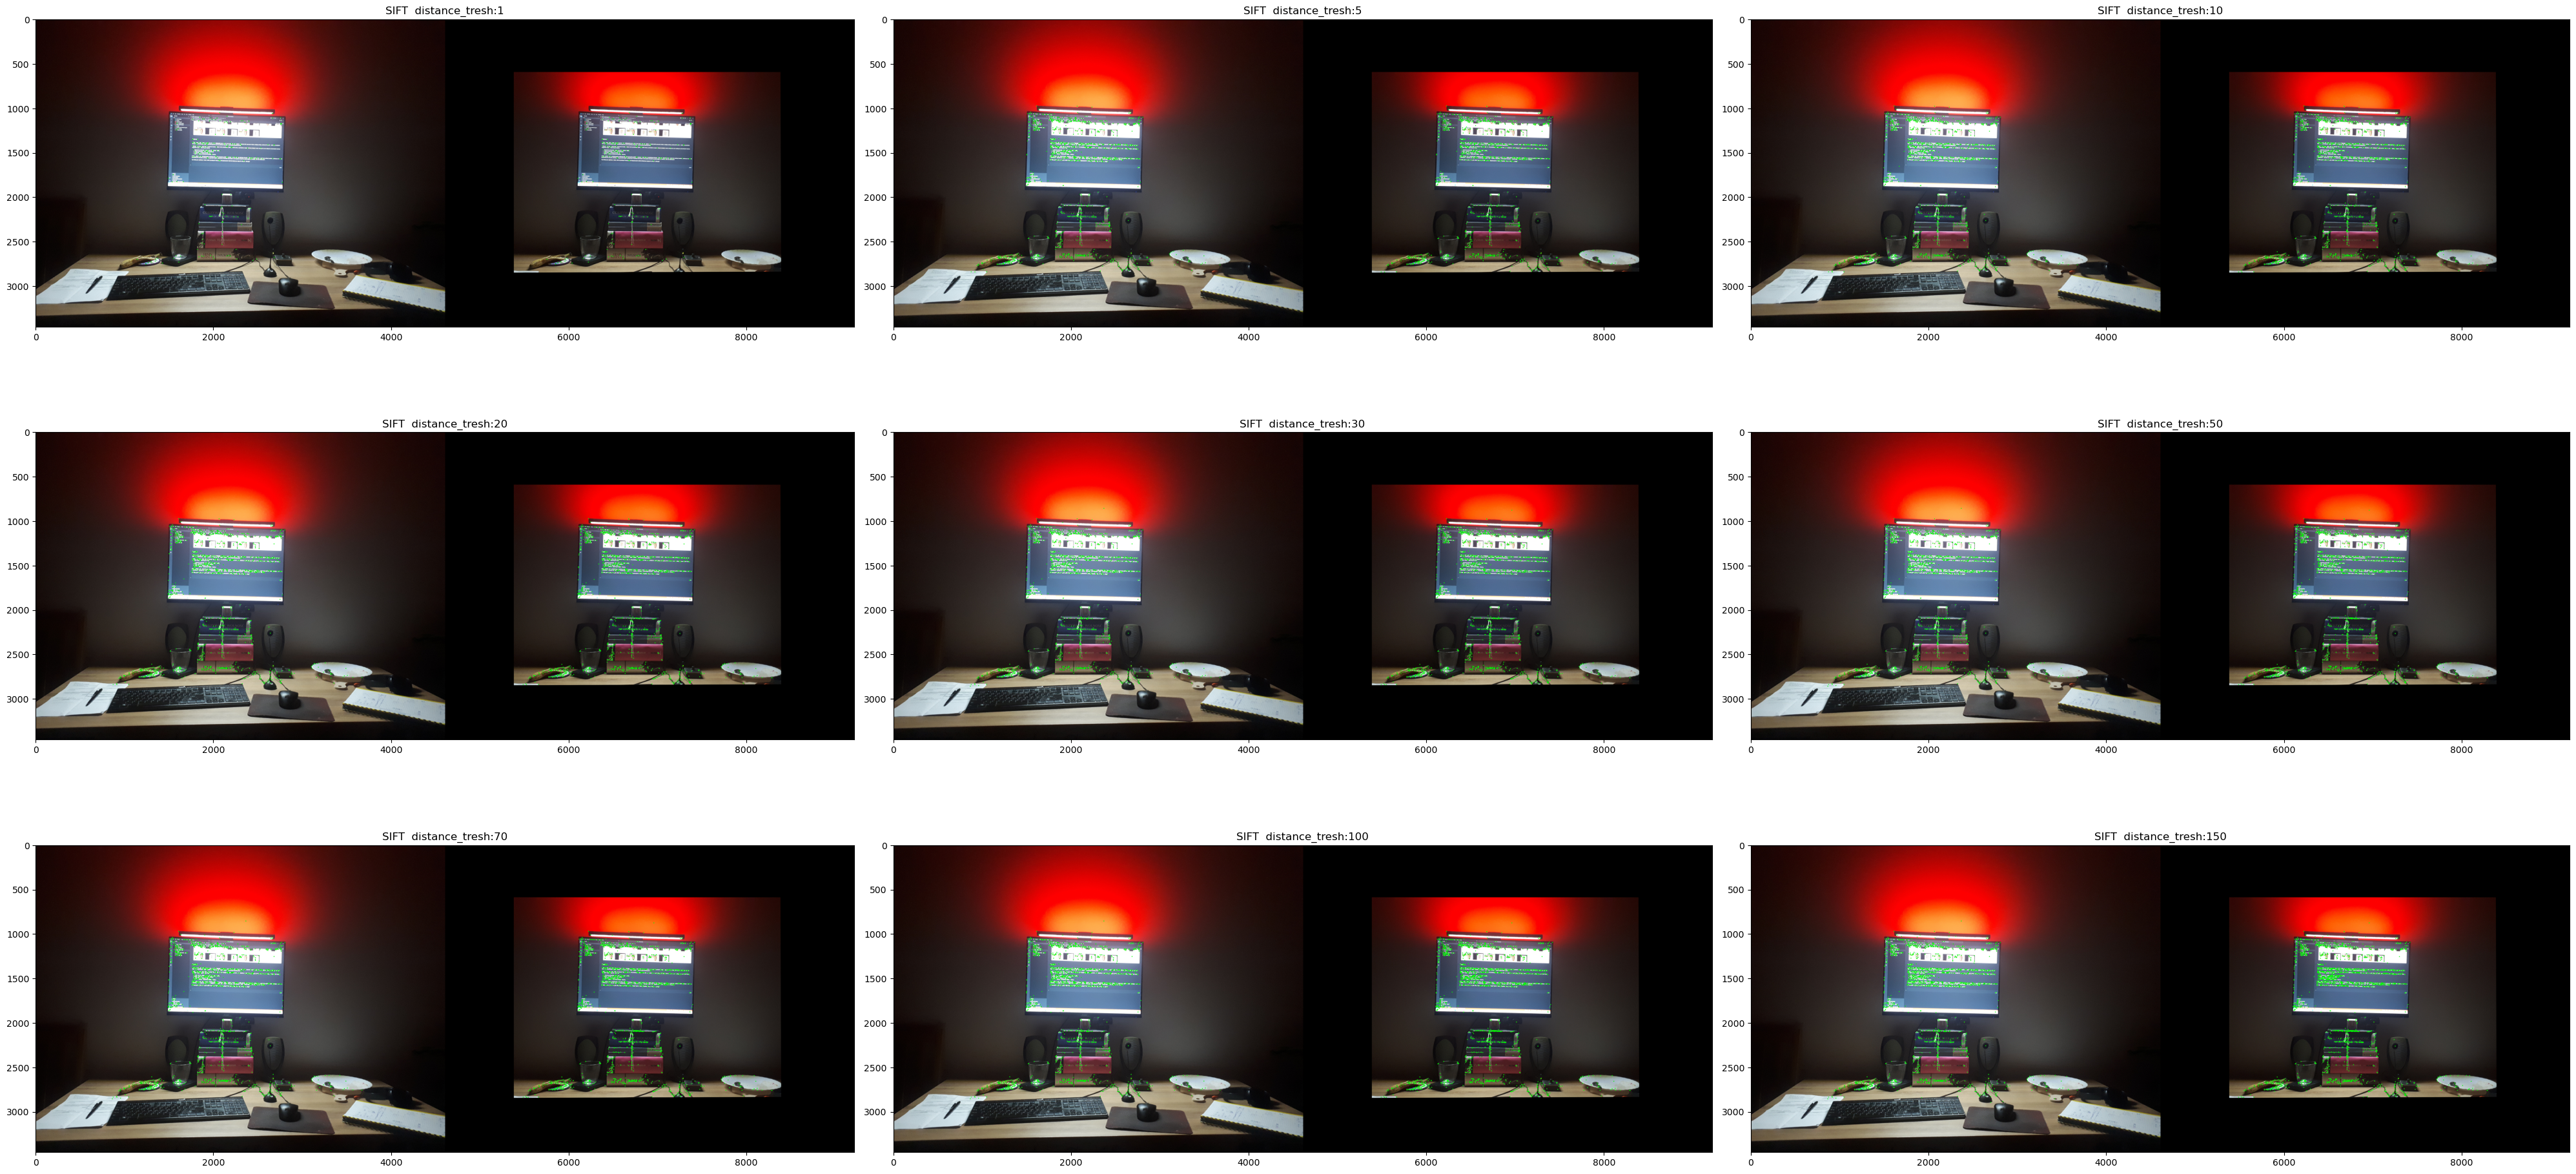

In [48]:
img1, img2 = zoom, basic


sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(img1, mask=None)
kp2, ds2 = sift.detectAndCompute(img2, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
N = 99999  # Możesz dostosować ilość punktów, którą chcesz użyć
selected_matches = matches[:N]
src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))


# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
closeness_values = [1, 5, 10, 20, 30, 50, 70, 100, 150]
plt.figure(figsize=(40, 20))
rows = 9
for x in range(rows):
    side_by_side = np.concatenate((img2, transformed_coke), axis=1)
    for match in selected_matches:
        pt1 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
        
        # Sprawdź odległość między punktami
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
        if distance < closeness_values[x]:
            pt2 = (pt2[0] + img2.shape[1], pt2[1])
            cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
            cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
    plt.subplot(3, 3, x+1)
    plt.imshow(side_by_side[...,::-1]), plt.title(f'SIFT  distance_tresh:{closeness_values[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

## Rot

In [ ]:
img1, img2 = rot, basic


sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(img1, mask=None)
kp2, ds2 = sift.detectAndCompute(img2, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
N = 99999  # Możesz dostosować ilość punktów, którą chcesz użyć
selected_matches = matches[:N]
src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))


# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
closeness_values = [1, 5, 10, 20, 30, 50, 70, 100, 150]
plt.figure(figsize=(40, 20))
rows = 9
for x in range(rows):
    side_by_side = np.concatenate((img2, transformed_coke), axis=1)
    for match in selected_matches:
        pt1 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
        
        # Sprawdź odległość między punktami
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
        if distance < closeness_values[x]:
            pt2 = (pt2[0] + img2.shape[1], pt2[1])
            cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
            cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
    plt.subplot(3, 3, x+1)
    plt.imshow(side_by_side[...,::-1]), plt.title(f'SIFT  distance_tresh:{closeness_values[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

## Left

In [ ]:
img1, img2 = left, basic


sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(img1, mask=None)
kp2, ds2 = sift.detectAndCompute(img2, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
N = 99999  # Możesz dostosować ilość punktów, którą chcesz użyć
selected_matches = matches[:N]
src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))


# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
closeness_values = [1, 5, 10, 20, 30, 50, 70, 100, 150]
plt.figure(figsize=(40, 20))
rows = 9
for x in range(rows):
    side_by_side = np.concatenate((img2, transformed_coke), axis=1)
    for match in selected_matches:
        pt1 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
        
        # Sprawdź odległość między punktami
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
        if distance < closeness_values[x]:
            pt2 = (pt2[0] + img2.shape[1], pt2[1])
            cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
            cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
    plt.subplot(3, 3, x+1)
    plt.imshow(side_by_side[...,::-1]), plt.title(f'SIFT  distance_tresh:{closeness_values[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

## Left more

In [ ]:
from tracemalloc import start
img1, img2 = left_hard, basic


sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(img1, mask=None)
kp2, ds2 = sift.detectAndCompute(img2, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
N = 99999  # Możesz dostosować ilość punktów, którą chcesz użyć
selected_matches = matches[:N]
src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))


# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
closeness_values = [1, 5, 10, 20, 30, 50, 70, 100, 150]
plt.figure(figsize=(40, 20))
rows = 9
for x in range(rows):
    side_by_side = np.concatenate((img2, transformed_coke), axis=1)
    for match in selected_matches:
        pt1 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
        
        # Sprawdź odległość między punktami
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
        if distance < closeness_values[x]:
            pt2 = (pt2[0] + img2.shape[1], pt2[1])
            cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
            cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
    plt.subplot(3, 3, x+1)
    plt.imshow(side_by_side[...,::-1]), plt.title(f'SIFT  distance_tresh:{closeness_values[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

## Out

In [ ]:
from tracemalloc import start
img1, img2 = out, basic


sift = cv2.SIFT_create()
kp1, ds1 = sift.detectAndCompute(img1, mask=None)
kp2, ds2 = sift.detectAndCompute(img2, mask=None)
matcher = cv2.BFMatcher_create()
matches = matcher.match(ds1, ds2)
N = 99999  # Możesz dostosować ilość punktów, którą chcesz użyć
selected_matches = matches[:N]
src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))


# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
closeness_values = [1, 5, 10, 20, 30, 50, 70, 100, 150]
plt.figure(figsize=(40, 20))
rows = 9
for x in range(rows):
    side_by_side = np.concatenate((img2, transformed_coke), axis=1)
    for match in selected_matches:
        pt1 = tuple(map(int, kp2[match.trainIdx].pt))
        pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
        
        # Sprawdź odległość między punktami
        distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
        if distance < closeness_values[x]:
            pt2 = (pt2[0] + img2.shape[1], pt2[1])
            cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
            cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
    plt.subplot(3, 3, x+1)
    plt.imshow(side_by_side[...,::-1]), plt.title(f'SIFT  distance_tresh:{closeness_values[x]}')
    


plt.tight_layout()
plt.show()

plt.show()

# Thresholds

In [ ]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999
img1, img2 = zoom, basic

# Sprawdź odległość między punktami
distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
edge_tresh = [1.1, 2, 5, 200]
contrast_tresh = [_, 0.005, 0.01, 0.04, 0.08]
plt.figure(figsize=(40, 20))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kp1, ds1 = sift.detectAndCompute(img1, mask=None)
        kp2, ds2 = sift.detectAndCompute(img2, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            
            selected_matches = matches[:N]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        except:
            continue
        transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
        
        
        
        side_by_side = np.concatenate((img2, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + img2.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')
    


plt.tight_layout()
plt.show()

plt.show()

In [ ]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999
img1, img2 = out, basic

# Sprawdź odległość między punktami
    
edge_tresh = [1.1, 2, 5, 20]
contrast_tresh = [_, 0.04, 0.08, 0.2, 0.4]
plt.figure(figsize=(40, 20))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kp1, ds1 = sift.detectAndCompute(img1, mask=None)
        kp2, ds2 = sift.detectAndCompute(img2, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            
            selected_matches = matches[:N]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
        except Exception as e:
            print(f"Wystąpił błąd: {str(e)}")
            continue
        
        
        
        
        side_by_side = np.concatenate((img2, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + img1.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')
    


plt.tight_layout()
plt.show()

plt.show()

In [ ]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999
img1, img2 = left, basic

# Sprawdź odległość między punktami
    
edge_tresh = [1.1, 2, 5, 20]
contrast_tresh = [_, 0.04, 0.08, 0.2, 0.4]
plt.figure(figsize=(40, 20))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kp1, ds1 = sift.detectAndCompute(img1, mask=None)
        kp2, ds2 = sift.detectAndCompute(img2, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            
            selected_matches = matches[:N]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
        except Exception as e:
            print(f"Wystąpił błąd: {str(e)}")
            continue
        
        
        
        
        side_by_side = np.concatenate((img2, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + img1.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')
    


plt.tight_layout()
plt.show()

plt.show()

In [ ]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999
img1, img2 = left_hard, basic

# Sprawdź odległość między punktami
    
edge_tresh = [1.1, 2, 5, 20]
contrast_tresh = [_, 0.04, 0.08, 0.2, 0.4]
plt.figure(figsize=(40, 20))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kp1, ds1 = sift.detectAndCompute(img1, mask=None)
        kp2, ds2 = sift.detectAndCompute(img2, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            
            selected_matches = matches[:N]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
        except Exception as e:
            print(f"Wystąpił błąd: {str(e)}")
            continue
        
        
        
        
        side_by_side = np.concatenate((img2, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + img1.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')
    


plt.tight_layout()
plt.show()

plt.show()

In [ ]:
from tracemalloc import start

N = 999999  # Możesz dostosować ilość punktów, którą chcesz użyć
closeness_value = 9999
img1, img2 = rot, basic

# Sprawdź odległość między punktami
    
edge_tresh = [1.1, 2, 5, 20]
contrast_tresh = [_, 0.04, 0.08, 0.2, 0.4]
plt.figure(figsize=(40, 20))
rows = 4
columns = 4
for x in range(rows):
    for y in range(1, columns+1):
        sift = cv2.SIFT_create(edgeThreshold=edge_tresh[x], contrastThreshold=contrast_tresh[y])
        kp1, ds1 = sift.detectAndCompute(img1, mask=None)
        kp2, ds2 = sift.detectAndCompute(img2, mask=None)
        try:
            matcher = cv2.BFMatcher_create()
            matches = matcher.match(ds1, ds2)
            
            selected_matches = matches[:N]
            src_pts = np.float32([kp1[m.queryIdx].pt for m in selected_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in selected_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            transformed_coke = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
        except Exception as e:
            print(f"Wystąpił błąd: {str(e)}")
            continue
        
        
        
        
        side_by_side = np.concatenate((img2, transformed_coke), axis=1)
        for match in selected_matches:
            pt1 = tuple(map(int, kp2[match.trainIdx].pt))
            pt2 = tuple(map(int, (cv2.perspectiveTransform(np.array([[kp1[match.queryIdx].pt]], dtype=np.float32), H))[0][0]))
            
            # Sprawdź odległość między punktami
            distance = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            
            # Nanieś punkt tylko jeśli odległość jest mniejsza niż closeness_value
            if distance < closeness_value:
                pt2 = (pt2[0] + img1.shape[1], pt2[1])
                cv2.circle(side_by_side, pt1, 5, (0, 255, 0), -1)
                cv2.circle(side_by_side, pt2, 5, (0, 255, 0), -1)
        plt.subplot(rows, columns, x*4+y)
        plt.imshow(side_by_side[..., ::-1], cmap='gray'), plt.title(f'SIFT  edge:{edge_tresh[x]}, contrast:{contrast_tresh[y]}')
    


plt.tight_layout()
plt.show()

plt.show()